# Oogeso - test case 2
Simple case for illustrating/testing the Oogeso model

In [60]:
%load_ext autoreload
%autoreload 2
from oogeso.plots import plots
import oogeso.io
import IPython
import pyomo.environ as pyo
import pandas as pd
import plotly.express as px
import logging
import json

logging.basicConfig()
logger = logging.getLogger()
logger.setLevel('INFO')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
profiles_dfs = oogeso.io.read_profiles_from_csv(
    filename_forecasts="../tests/test_data/testcase2_profiles_forecasts.csv",
    filename_nowcasts="../tests/test_data/testcase2_profiles_nowcasts.csv",timestamp_col="timestamp",exclude_cols=["timestep"])
profiles_json = oogeso.utils.create_time_series_data(profiles_dfs["forecast"],profiles_dfs["nowcast"],
                                      time_start=None,time_end=None,timestep_minutes=15)
data0 = oogeso.io.read_data_from_yaml('../tests/test_data/testcase2_inputdata.yaml')
data0.profiles = [x for x in profiles_json if x.id in ["wind","demand"]]

In [62]:
#with open("testdata.json","w") as f:
#    f.write(oogeso.dto.serialisation.serialize_oogeso_data(data0))

In [63]:
simulator = oogeso.Simulator(data=data0)
optimiser = simulator.optimiser

INFO:oogeso.core.optimiser:profiles in use: ['wind', 'demand']
INFO:oogeso.core.optimiser:Using objective function: exportRevenue


In [64]:
#optimiser.constr_GT1_misc.pprint()

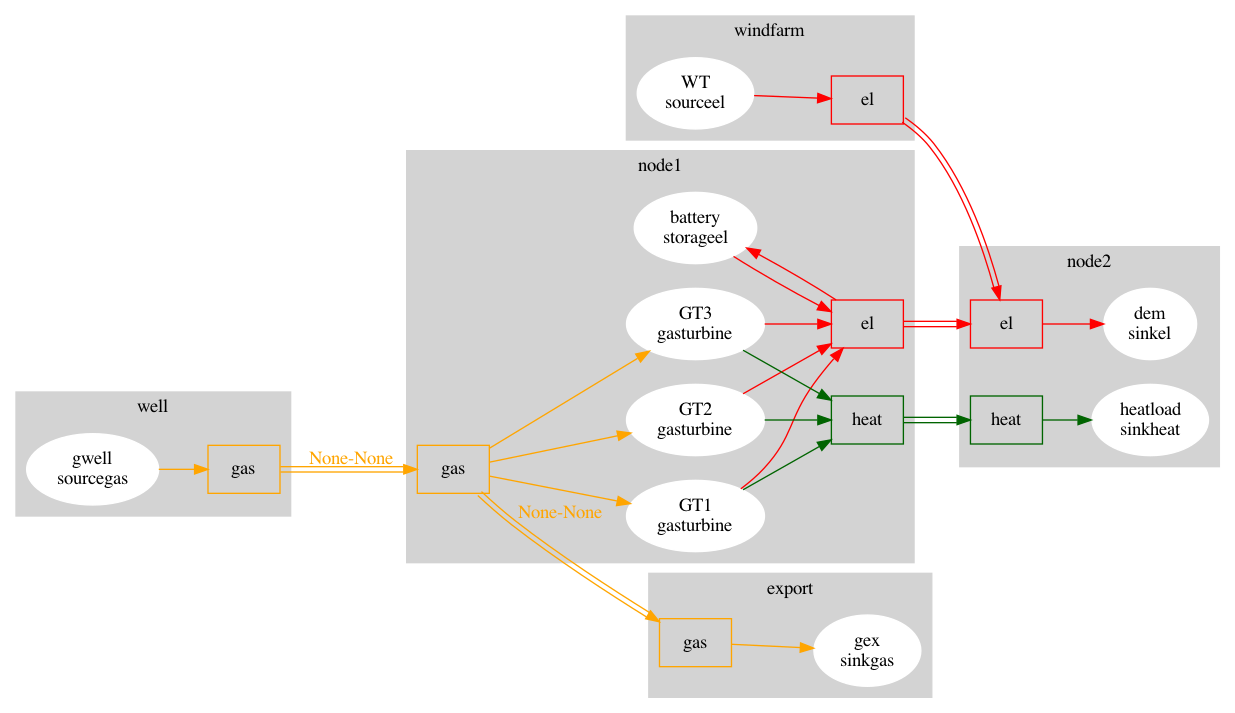

In [65]:
IPython.display.Image(plots.plot_network(simulator,timestep=None).create_png())

In [66]:
res = simulator.run_simulation(solver="cbc",time_range=[0,90],write_yaml=False)

100%|██████████| 23/23 [00:05<00:00,  4.59it/s]


In [67]:
# import oogeso.dto.serialisation
# with open("testcase2_resultobject.json", "w") as outfile:
#    json.dump(res, fp=outfile, cls=oogeso.dto.serialisation.DataclassJSONEncoder, indent=2)

In [68]:
#json_str = json.dumps(data_dict)
#decoder = DataclassJSONDecoder()
#energy_system = decoder.decode(json_str)

# Open saved result for comparison
with open("../tests/test_data/testcase2_resultobject.json", "r") as infile:
    res2 = json.load(infile,cls=oogeso.dto.serialisation.OogesoResultJSONDecoder)
    #res2=oogeso.dto.serialisation.deserialize_oogeso_results(json_data=json_data)

In [69]:
res.device_starting

device  time
GT1     0       0.0
        1       0.0
        2       0.0
        3       0.0
        4       0.0
               ... 
GT3     87      0.0
        88      0.0
        89      0.0
        90      0.0
        91      0.0
Name: value, Length: 276, dtype: float64

In [70]:
import numpy as np
(res2.co2_rate_per_dev-res.co2_rate_per_dev)

device    time
GT1       0       0.0
          1       0.0
          2       0.0
          3       0.0
          4       0.0
                 ... 
heatload  87      0.0
          88      0.0
          89      0.0
          90      0.0
          91      0.0
Length: 828, dtype: object

In [71]:
gt='GT2'
print("GT is on initially ={}".format(pyo.value(optimiser.paramDeviceIsOnInitially[gt])))
print("GT timesteps in startup preparation = {}".format(pyo.value(optimiser.paramDevicePrepTimestepsInitially[gt])))
for t in range(4):
    cstr=getattr(optimiser, "constr_{}_startstop".format(gt))[t]
    #cstr=optimiser.constrDevice_startup_shutdown[gt,t]
    print("t={}: {} = {}".format(t,cstr.body,cstr.upper))
for t in range(4):
    cstr=getattr(optimiser, "constr_{}_startdelay".format(gt))[t]
    #cstr=optimiser.constrDevice_startup_delay[gt,t]
    print("t={}: {} = {}".format(t,cstr.body,cstr.upper))
for t in range(4):
    cstr=getattr(optimiser, "constr_{}_flowMax".format(gt))[t]
    #cstr=optimiser.constrDevicePmax[gt,t]
    print("t={}: {} = {}".format(t,cstr.body,cstr.upper))

GT is on initially =0
GT timesteps in startup preparation = 0
t=0: varDeviceIsOn[GT2,0] - paramDeviceIsOnInitially[GT2] + varDeviceStopping[GT2,0] = 0.0
t=1: varDeviceIsOn[GT2,1] - varDeviceIsOn[GT2,0] + varDeviceStopping[GT2,1] = 0.0
t=2: varDeviceIsOn[GT2,2] - varDeviceIsOn[GT2,1] + varDeviceStopping[GT2,2] = 0.0
t=3: varDeviceIsOn[GT2,3] - varDeviceIsOn[GT2,2] - (varDeviceStarting[GT2,0] - varDeviceStopping[GT2,3]) = 0.0
t=0: varDeviceIsPrep[GT2,0] - varDeviceStarting[GT2,0] = 0.0
t=1: varDeviceIsPrep[GT2,1] - (varDeviceStarting[GT2,1] + varDeviceStarting[GT2,0]) = 0.0
t=2: varDeviceIsPrep[GT2,2] - (varDeviceStarting[GT2,2] + varDeviceStarting[GT2,1] + varDeviceStarting[GT2,0]) = 0.0
t=3: varDeviceIsPrep[GT2,3] - (varDeviceStarting[GT2,3] + varDeviceStarting[GT2,2] + varDeviceStarting[GT2,1]) = 0.0
t=0: varDeviceFlow[GT2,el,out,0] - 20*varDeviceIsOn[GT2,0] = 0.0
t=1: varDeviceFlow[GT2,el,out,1] - 20*varDeviceIsOn[GT2,1] = 0.0
t=2: varDeviceFlow[GT2,el,out,2] - 20*varDeviceIsOn[GT2,2

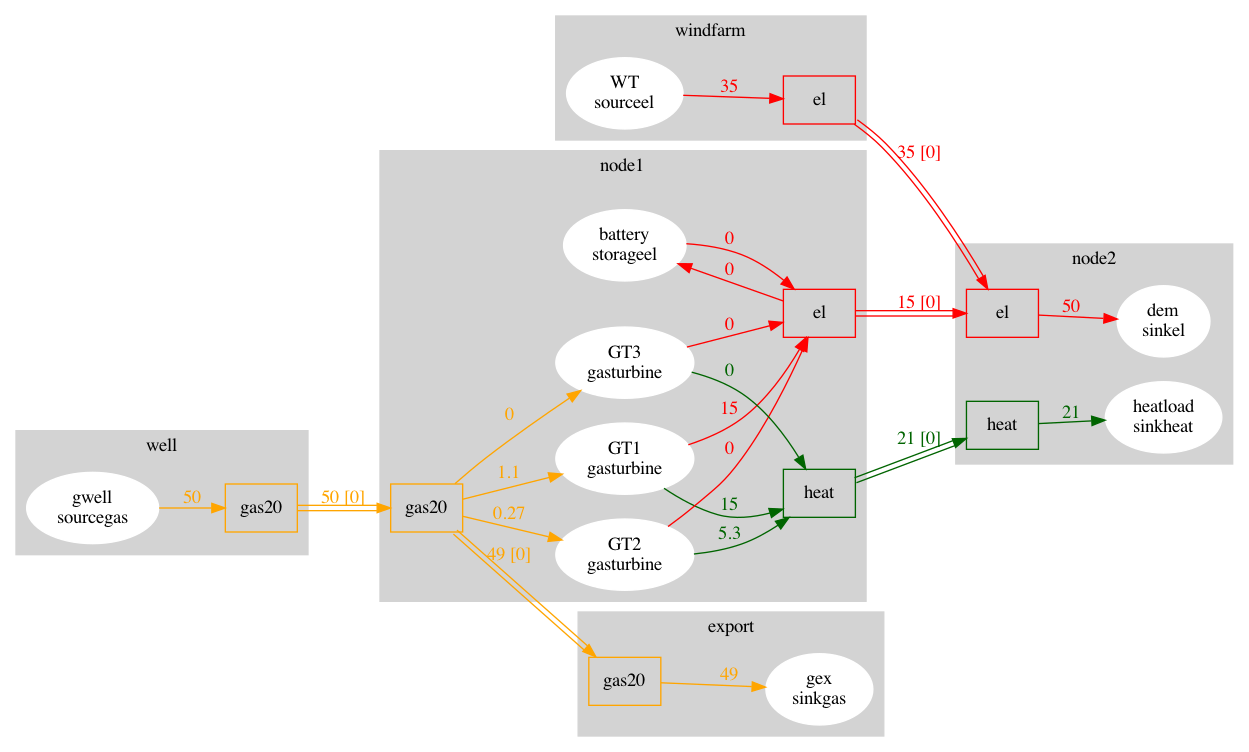

In [72]:
dotG=plots.plot_network(simulator=simulator,timestep=15,filename=None)
#IPython.display.SVG(dotG.create_svg()) #original size, vector graphics
IPython.display.Image(dotG.create_png()) #scales automatically to page width

In [73]:
plots.plot_sum_power_mix(res,optimisation_model=simulator.optimiser,carrier="el").show()

<AxesSubplot:xlabel='time'>

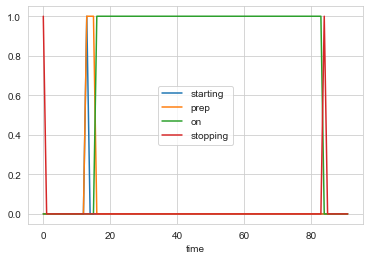

In [74]:
# Problem = isOn = isPrep, isStarting=0
gt='GT2'
dfStart=pd.concat([
    res.device_starting[gt],
    res.device_is_prep[gt],
    res.device_is_on[gt],
    res.device_stopping[gt]],axis=1)
dfStart.columns=['starting','prep','on','stopping']
dfStart.plot()

In [75]:
plots.plot_device_profile(res,optimisation_model=simulator.optimiser,devs=['GT1','GT2','GT3'],include_on_off=True,include_prep=True)

In [76]:
#plots.plot_CO2rate(mc)
plots.plot_CO2_rate_per_device(res,optimisation_model=simulator.optimiser,device_shareload=None)

In [77]:
plots.plot_reserve(res,simulator.optimiser)

In [78]:
plots.plot_el_backup(res,show_margin=True)

In [79]:
dfplot=res.el_reserve
margin=optimiser.all_networks["el"].carrier_data.el_reserve_margin
x = [dfplot.index[0],dfplot.index[-1]]
fig=px.line(dfplot,title="Reserve")
fig.add_scatter(x=x,y=[margin,margin],line=dict(dash='dot'),name="margin",mode="lines")
fig.update_xaxes(title_text="Timestep")
fig.update_yaxes(title_text="Reserve power (MW)",dtick = 5)
fig.update_layout(autosize=False,width=800,height=300,margin=dict(l=0,r=0,t=30,b=0))

In [80]:
if 'battery' in optimiser.setDevice:
    fig=oogeso.plots.plot_device_power_energy(res,optimisation_model=simulator.optimiser,dev='battery',filename=None)
    fig.update_layout(autosize=False,width=800,height=300,margin=dict(l=0,r=0,t=30,b=0)).show()
    #print("Last optimisation scheduling:")
    #oogeso.milp_plot.plotDevicePowerLastOptimisation1(optimiser,device='battery',
    #            filename=None)